In [1]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string
dataset_size = 500

Using TensorFlow backend.


In [2]:
def concate_files(file1,file2,final_file):
      data = data2 = ""
      with open(file1, 'r', encoding='utf-8') as fp:  # Reading data from file1
            sentences = fp.readlines()
            for sentence in sentences[:int(dataset_size)]:
                  data += sentence
      with open(file2, 'r', encoding='utf-8') as fp:  # Reading data from file2
            sentences = fp.readlines()
            for sentence in sentences[:int(dataset_size)]:
                  data2 += sentence
      data += data2  # To add the data of file2
      with open (final_file, 'w', encoding='utf-8') as fp:
            fp.write(data)
concate_files('data/total/pos.txt','data/total/neg.txt','data/total/labeled_text.txt')

In [3]:
data = pd.read_csv('data/total/labeled_text.txt', header = None, delimiter='    ',encoding='utf-8',names=['Label', 'Text'])
data.head()

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Label,Text
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


In [4]:
data.Label.unique()

array([ 1, -1], dtype=int64)

In [5]:
data.shape

(1000, 2)

In [6]:
#Assign Label to each sentence
PosNegLabel = []
for label in data.Label:
    if label == -1:        #negative
        PosNegLabel.append(0)
    elif label == 1:      #positive
        PosNegLabel.append(1)
data['Label']= PosNegLabel
data.head()

,Label,Text
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


In [7]:
stopword_ls = []
def getStopWord():
    with open('lib/stopwords_utf8.txt', 'r',encoding='UTF-8') as file:
        for line in file:
            stopword_ls.append(line.split('\n')[0])
getStopWord()

def isStopWord(word):
    for i in range(len(stopword_ls)):
        if word == stopword_ls[i]:
            return True
    return False

In [8]:
import jieba
import random
def load_data():   #获取数据集
    data = []
    getStopWord()
    positive_line = 0
    negative_line = 0
    total_positive_line = dataset_size
    total_negative_line = dataset_size

    with open('data/total/pos.txt', 'r', encoding='utf-8') as f:
        print('File Directory: data/total/pos.txt')
        sentences = f.readlines()
        for sentence in sentences[:total_positive_line]:
            positive_line += 1
            if positive_line == total_positive_line:
                end_val = '\n'
            else:
                end_val = '\r'
            print('Getting positive sentence {}/{}'.format(positive_line,total_positive_line),end=end_val)
            word_ls = []
            words = sentence.replace('\n','').split('    ')   #get chinese sentence
            tmp_ls = list(jieba.cut(words[1], cut_all=True))   #segmentation
            for i in range(len(tmp_ls)):
                if not isStopWord(tmp_ls[i]):
                       word_ls.append(tmp_ls[i]) 
            data.append([word_ls, 0])

    with open('data/total/neg.txt', 'r', encoding='utf-8') as f:
        print('File Directory: data/total/neg.txt')
        sentences = f.readlines()
        for sentence in sentences[:total_negative_line]:
            negative_line += 1
            if negative_line == total_negative_line:
                end_val = '\n'
            else:
                end_val = '\r'
            print('Getting negative sentence {}/{}'.format(negative_line,total_negative_line),end=end_val)
            word_ls = []
            words = sentence.replace('\n','').split('    ')   #get chinese sentence
            tmp_ls = list(jieba.cut(words[1], cut_all=True))   #segmentation
            for i in range(len(tmp_ls)):
                if not isStopWord(tmp_ls[i]):
                       word_ls.append(tmp_ls[i]) 
            data.append([word_ls, 1])

    print('Positive Line: {} | Negative Line: {}'.format(positive_line,negative_line))
    random.shuffle(data)
    return data

In [9]:
import jieba
from snownlp import SnowNLP
import random

def jieba_segment(text):
    word_ls = []
    tmp_ls = list(jieba.cut(text, cut_all=False))   #segmentation
    for i in range(len(tmp_ls)):
        if not isStopWord(tmp_ls[i]):
            word_ls.append(tmp_ls[i]) 
    return word_ls

def snow_segment(text):
    word_ls = []
    tmp_ls = SnowNLP(text).words  #segmentation  
    for i in range(len(tmp_ls)):
        if not isStopWord(tmp_ls[i]):
            word_ls.append(tmp_ls[i]) 
    return word_ls

random.shuffle(data['Text'])
#data['Segmented_Text'] = data['Text'].apply(lambda x: jieba_segment(x))
data['Segmented_Text'] = data['Text'].apply(lambda x: snow_segment(x))
data.head()

d:\Downloads\python3.6\lib\random.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]


,Label,Text,Segmented_Text
0,1,在携程上订了一天，实际入住两天，酒店照携程价加收了一天房费，并为我免费升级了商务房。中间问酒...,"[携程, 上订, 天, 入住, 两, 天, 酒店, 携程, 价, 加收, 天房, 费, 免费..."
1,1,"这个店太差房间有霉味,最不能忍受的是前台工作效率极低极低!","[店, 太, 差, 房间, 霉味, 能忍受, 前台, 工作, 效率, 低, 低]"
2,1,标准的商务酒店，最大的优点就是位置好。房间比较干净，设施还行，但有些细节还需要改进。楼层服务...,"[标准, 商务, 酒店, 优点, 位置, 房间, 干净, 设施, 还行, 细节, 改进, 楼..."
3,1,北京的酒店，也就是这么着了！五星级酒店也就三星的水平，何况四星的呢，凑合着住吧,"[北京, 酒店, 五星级, 酒店, 三星, 水平, 四星, 凑合, 住]"
4,1,知道网线接口在哪儿吗？比高家庄的地道口还隐蔽。在床头柜后面！想不道吧？看你怎么用。1：自带4...,"[网线, 接口, 高家庄, 道口, 隐蔽, 床头, 柜, 想, 不道, 。1：, 米, 网线..."


In [10]:
data_train, data_test = train_test_split(data, test_size=0.20)

In [11]:
all_training_words = [word for tokens in data_train["Segmented_Text"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["Segmented_Text"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("TRAIN DATASET | Total Words:{} | Total Vocabulary:{} | Max Sentence Length:{}".format(len(all_training_words),len(TRAINING_VOCAB),max(training_sentence_lengths)))

all_test_words = [word for tokens in data_test["Segmented_Text"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["Segmented_Text"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("TEST  DATASET | Total Words:{}  | Total Vocabulary:{} | Max Sentence Length:{}" .format(len(all_test_words),len(TEST_VOCAB),max(test_sentence_lengths)))

TRAIN DATASET | Total Words:32533 | Total Vocabulary:6003 | Max Sentence Length:578
TEST  DATASET | Total Words:8687  | Total Vocabulary:2800 | Max Sentence Length:578


In [12]:
import torch
from tqdm import tqdm
from torchtext.legacy import vocab
import torchtext.vocab as Vocab
import torch.utils.data as Data
import torch.nn.functional as F
from torch import nn
import time

def get_vocab(data):
    tokenized_data = [words for words, _ in data]
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return vocab.Vocab(counter, min_freq=5)

def preprocess(data, vocab):  #data:list | vocab:torchtext.legacy.vocab.Vocab
    max_l = 500  # 将每条评论通过截断或者补0，使得长度变成500

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = [words for words, _ in data]
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0])  # 初始化为0
    oov_count = 0  # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("Words Out of Vocabulary: {}".format(oov_count))
    return embed

def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval()  # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train()  # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    opt_test_acc = 0
    train_acc_ls,test_acc_ls,loss_ls = [],[],[]
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in tqdm(train_iter):
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        train_acc_ls.append(train_acc_sum / n)
        test_acc_ls.append(test_acc)
        loss_ls.append(train_l_sum / batch_count)
    return train_acc_ls,test_acc_ls,loss_ls

d:\Downloads\python3.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
data_train_ls, data_test_ls = [], []
train_text_ls, train_label_ls = list(data_train.Segmented_Text), list(data_train.Label)
test_text_ls, test_label_ls = list(data_test.Segmented_Text), list(data_test.Label)
for i in range(len(train_text_ls)):
      data_train_ls.append([train_text_ls[i],train_label_ls[i]])
for i in range(len(test_text_ls)):
      data_test_ls.append([test_text_ls[i],test_label_ls[i]])
data_train.head()

,Label,Text,Segmented_Text
124,1,"非常好!订的是标房,入住当天升级为豪标.房间干净,服务热情.如果房间的窗户能打开(透透气),...","[订, 标房, 入住, 当天, 升级, 为豪, 标, 房间, 干净, 服务, 热情, 房间,..."
121,1,"一般我是懒的去评价住过的酒店的,这次选择""金泰海博"",是因为新公司就在对面,图个方便,但是,...","[我是, 懒, 评价, 住, 酒店, 选择, 金, 泰海, 博, "",, 新, 公司, 对面..."
255,1,"硬件设施太旧,和房价不相符,价格还是贵了补充点评2008年7月29日：大床房的床太小,两人睡...","[硬件, 设施, 太, 旧, 房价, 相符, 价格, 贵, 补充, 点评, 2008, 年,..."
418,1,房间不干净，设施陈旧。以后不会再住，还是格林豪泰或如家比较好。,"[房间, 干净, 设施, 陈旧, 住, 格林豪, 泰, 或如家]"
877,0,房间太小，无电梯，周围环境还可以，但正在修路，非常嘈杂,"[房间, 太, 电梯, 环境, 正, 修路, 嘈杂]"


In [14]:
batch_size = 64
train_data, test_data = train_test_split(load_data(), test_size=0.2)
vocabs = get_vocab(train_data)
print('Words in Vocabulary: {}'.format(len(vocabs)))
train_set = Data.TensorDataset(*preprocess(train_data, vocabs))
test_set = Data.TensorDataset(*preprocess(test_data, vocabs))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache


File Directory: data/total/pos.txt


Loading model cost 0.901 seconds.
Prefix dict has been built successfully.


Getting positive sentence 500/500
File Directory: data/total/neg.txt
Getting negative sentence 500/500
Positive Line: 500 | Negative Line: 500
Words in Vocabulary: 1385


In [15]:
class GlobalMaxPool1d(nn.Module): # 用一维池化层实现时序最大池化层
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()

    def forward(self, x):
        # x shape: (batch_size, channel, seq_len)
        # return shape: (batch_size, channel, 1)
        return F.max_pool1d(x, kernel_size=x.shape[2])


class CNN(nn.Module):
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # 不参与训练的嵌入层
        self.constant_embedding = nn.Embedding(len(vocab), embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 时序最大池化层没有权重，所以可以共用一个实例
        self.pool = GlobalMaxPool1d()
        self.convs = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels=2 * embed_size,
                                        out_channels=c,
                                        kernel_size=k))

    def forward(self, inputs):
        # 将两个形状是(批量大小, 词数, 词向量维度)的嵌入层的输出按词向量连结
        embeddings = torch.cat((
            self.embedding(inputs),
            self.constant_embedding(inputs)), dim=2)  # (batch, seq_len, 2*embed_size)
        # 根据Conv1D要求的输入格式，将词向量维，即一维卷积层的通道维(即词向量那一维)，变换到前一维
        embeddings = embeddings.permute(0, 2, 1)
        # 对于每个一维卷积层，在时序最大池化后会得到一个形状为(批量大小, 通道大小, 1)的
        # Tensor。使用flatten函数去掉最后一维，然后在通道维上连结
        encoding = torch.cat([self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs], dim=1)
        # 应用丢弃法后使用全连接层得到输出
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_size, kernel_sizes, nums_channels = 300, [3, 4, 5], [300, 300, 300]
net = CNN(vocabs, embed_size, kernel_sizes, nums_channels)

cache = '.vector_cache'
if not os.path.exists(cache):
    os.mkdir(cache)
glove_vocab = Vocab.Vectors(name='data/sgns.baidubaike.bigram-char', cache=cache)
net.embedding.weight.data.copy_(
    load_pretrained_embedding(vocabs.itos, glove_vocab))
net.constant_embedding.weight.data.copy_(
    load_pretrained_embedding(vocabs.itos, glove_vocab))
net.constant_embedding.weight.requires_grad = False

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train_acc_ls,test_acc_ls,loss_ls = train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

Words Out of Vocabulary: 62
Words Out of Vocabulary: 62
training on  cpu


100%|██████████| 13/13 [00:52<00:00,  4.06s/it]


epoch 1, loss 0.5925, train acc 0.689, test acc 0.700, time 57.1 sec


100%|██████████| 13/13 [00:45<00:00,  3.48s/it]


epoch 2, loss 0.1633, train acc 0.863, test acc 0.785, time 48.5 sec


100%|██████████| 13/13 [00:42<00:00,  3.25s/it]


epoch 3, loss 0.0669, train acc 0.924, test acc 0.830, time 45.6 sec


100%|██████████| 13/13 [00:42<00:00,  3.27s/it]


epoch 4, loss 0.0266, train acc 0.969, test acc 0.835, time 46.5 sec


100%|██████████| 13/13 [00:43<00:00,  3.37s/it]


epoch 5, loss 0.0111, train acc 0.999, test acc 0.835, time 47.1 sec


In [17]:
print(net)

CNN(
  (embedding): Embedding(1385, 300)
  (constant_embedding): Embedding(1385, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=900, out_features=2, bias=True)
  (pool): GlobalMaxPool1d()
  (convs): ModuleList(
    (0): Conv1d(600, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(600, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(600, 300, kernel_size=(5,), stride=(1,))
  )
)


Text(0, 0.5, 'loss')

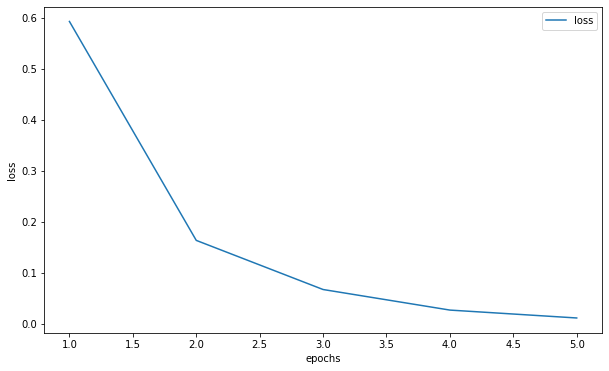

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
x = [*range(1, num_epochs+1, 1)]
plt.plot(x, loss_ls, label='loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

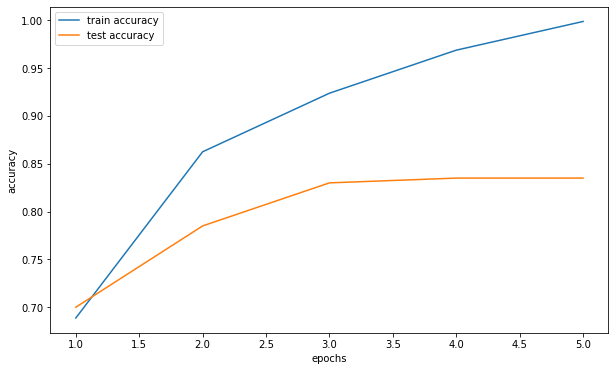

In [19]:
plt.figure(figsize=(10,6))
plt.plot(x, train_acc_ls, label='train accuracy')
plt.plot(x, test_acc_ls, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')